# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "SAS_3"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

    time  censor  SEX   AGE  RACE  PRHNTRTC  CARBOADD  CARBO2D  B_ECOG  \
0  984.0     1.0    0  21.0     4         1         0        0       0   
1  214.0     1.0    1  21.0     4         1         0        0       2   
2  218.0     0.0    0  23.0     4         1         0        0       2   
3  242.0     1.0    1  26.0     4         0         0        0       2   
4   55.0     1.0    1  26.0     4         1         0        0       2   

   DIAGTYPE  
0         3  
1         3  
2         0  
3         3  
4         3  


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

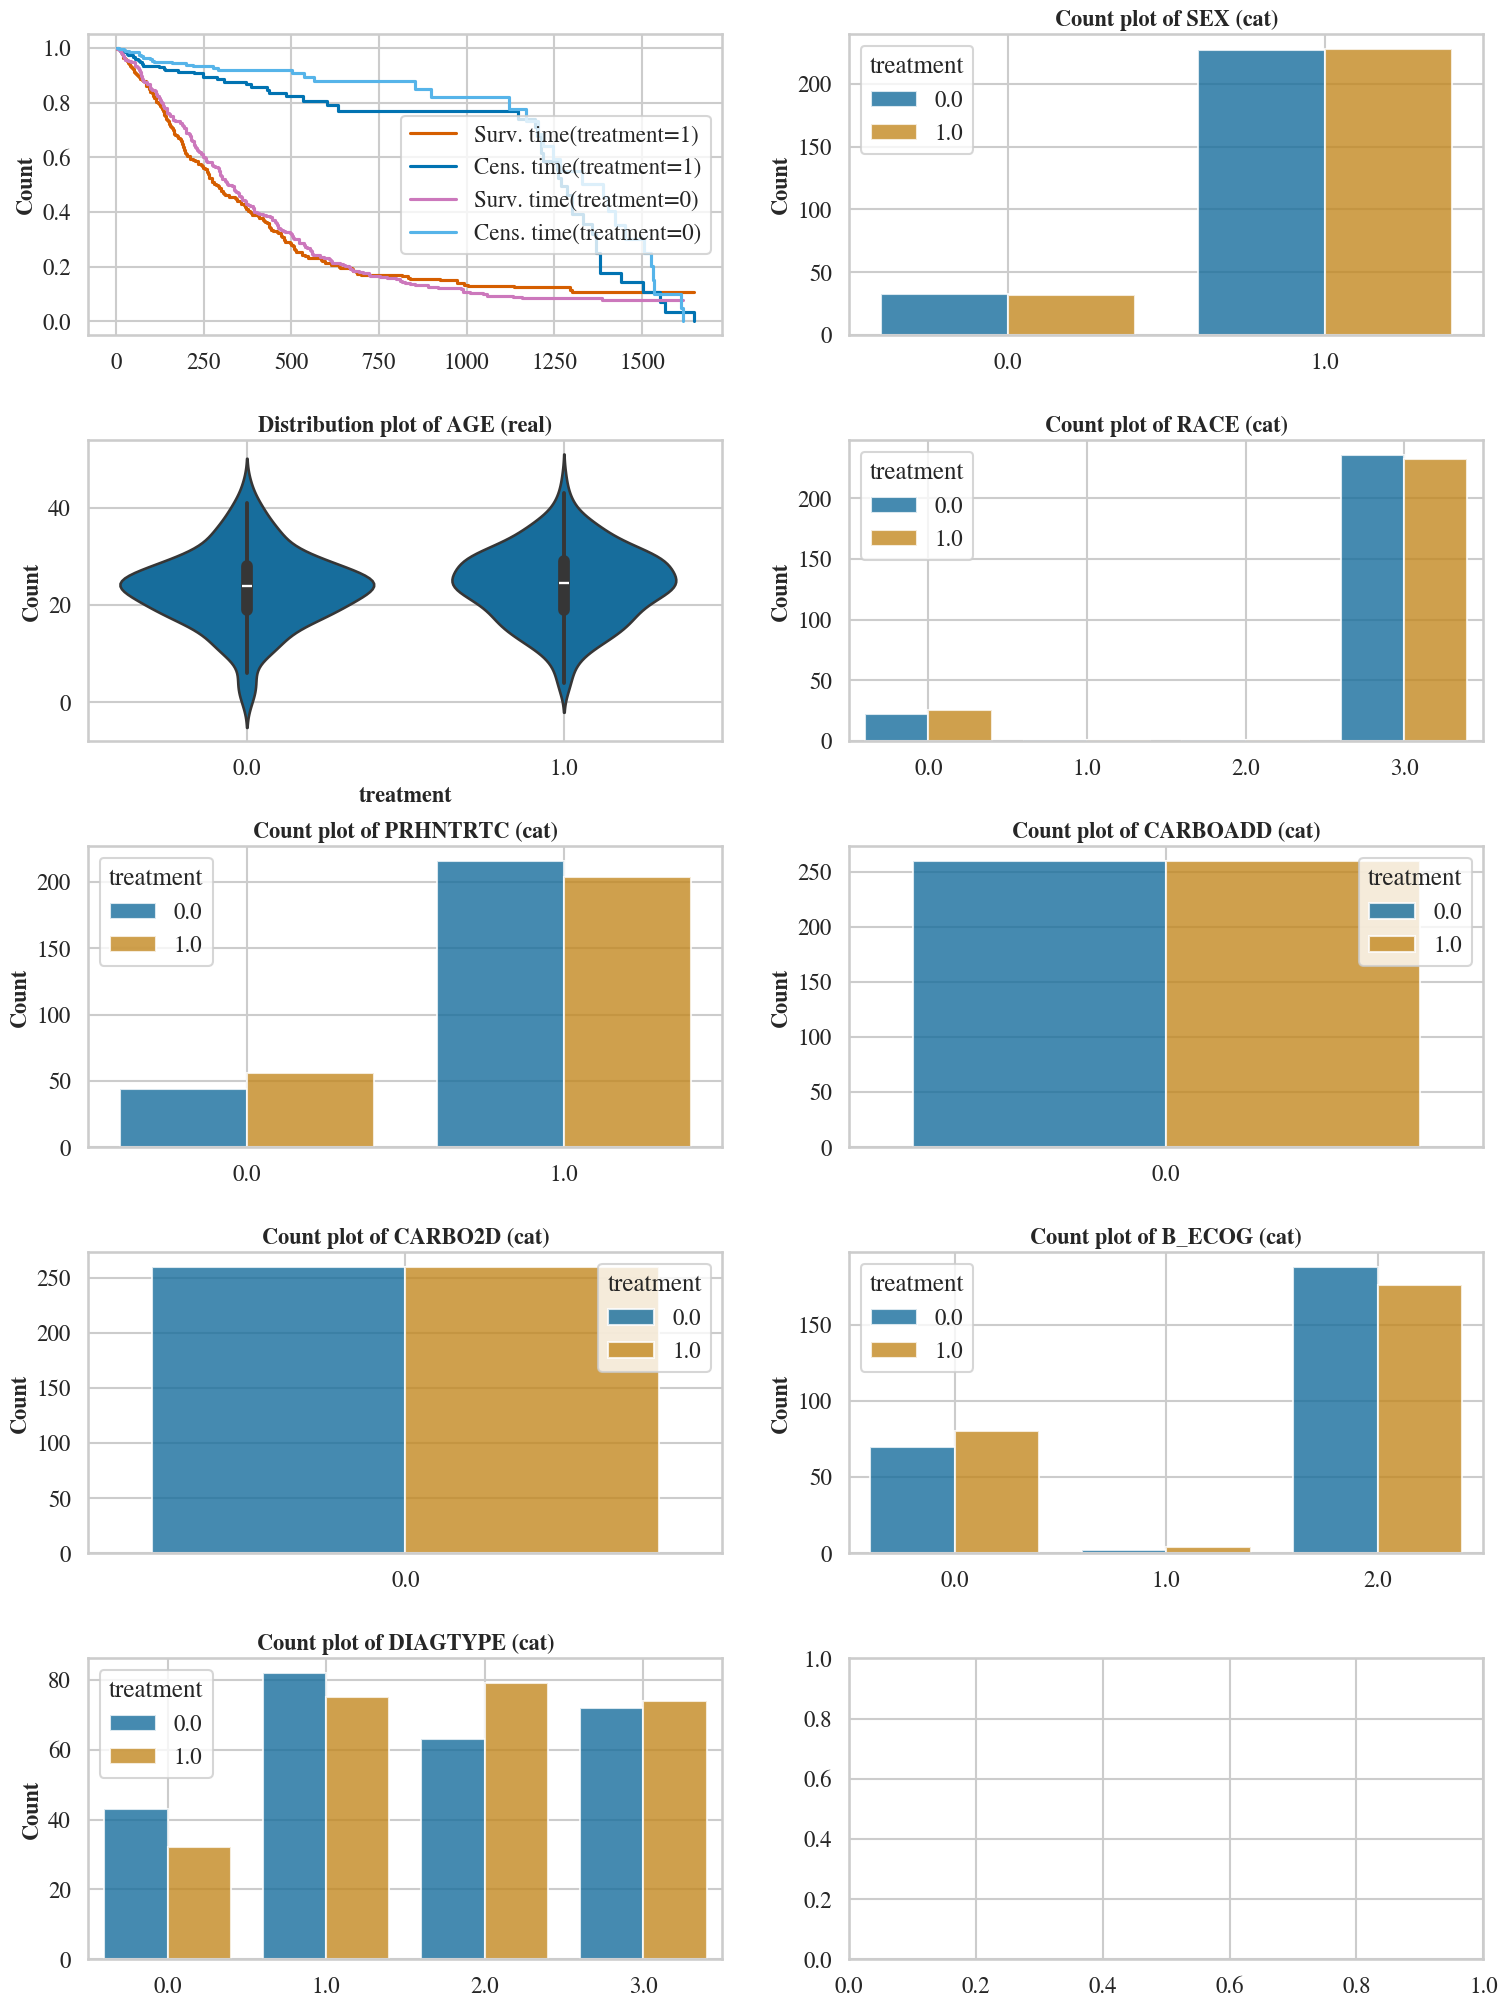

In [6]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [7]:
categorical = ['censor', 'SEX', 'RACE', 'PRHNTRTC', 'CARBOADD', 'CARBO2D', 'B_ECOG', 'DIAGTYPE', 'treatment']
continuous = ['time', 'AGE']
nonnormal = ['time']

table1 = TableOne(df_init, categorical=categorical, continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                       
                                      Missing              Overall                    0                    1 P-Value
n                                                              520                  260                  260        
time, median [Q1,Q3]                        0  273.5 [127.5,507.2]  296.0 [133.8,536.5]  252.0 [119.2,480.5]   0.109
censor, n (%)        0.0                                 95 (18.3)            39 (15.0)            56 (21.5)   0.069
                     1.0                                425 (81.7)           221 (85.0)           204 (78.5)        
SEX, n (%)           0.0                                 65 (12.5)            33 (12.7)            32 (12.3)   1.000
                     1.0                                455 (87.5)           227 (87.3)           228 (87.7)        
AGE, mean (SD)                              0           23.8 (7.

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [8]:
from execute import surv_hivae, surv_gan

# the datasets used for training is data_init_control
n_generated_dataset = 100
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals =  10
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [9]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset, batch_size=30)

Epoch: [ 0]  time: 0.0497, ELBO_train: -10.59427329, KL_z: 1.10311279, KL_s: 0.05838346, reconstruction loss: -9.43277704
Epoch: [100]  time: 6.1359, ELBO_train: -7.00333084, KL_z: 0.22240729, KL_s: 0.01891559, reconstruction loss: -6.76200797
Epoch: [200]  time: 11.3817, ELBO_train: -6.85765682, KL_z: 0.24195744, KL_s: 0.01477402, reconstruction loss: -6.60092536
Epoch: [300]  time: 16.2359, ELBO_train: -6.69716406, KL_z: 0.25970907, KL_s: 0.01645006, reconstruction loss: -6.42100493
Epoch: [400]  time: 21.2837, ELBO_train: -6.71592651, KL_z: 0.29743413, KL_s: 0.01810936, reconstruction loss: -6.40038303
Training finished.


## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

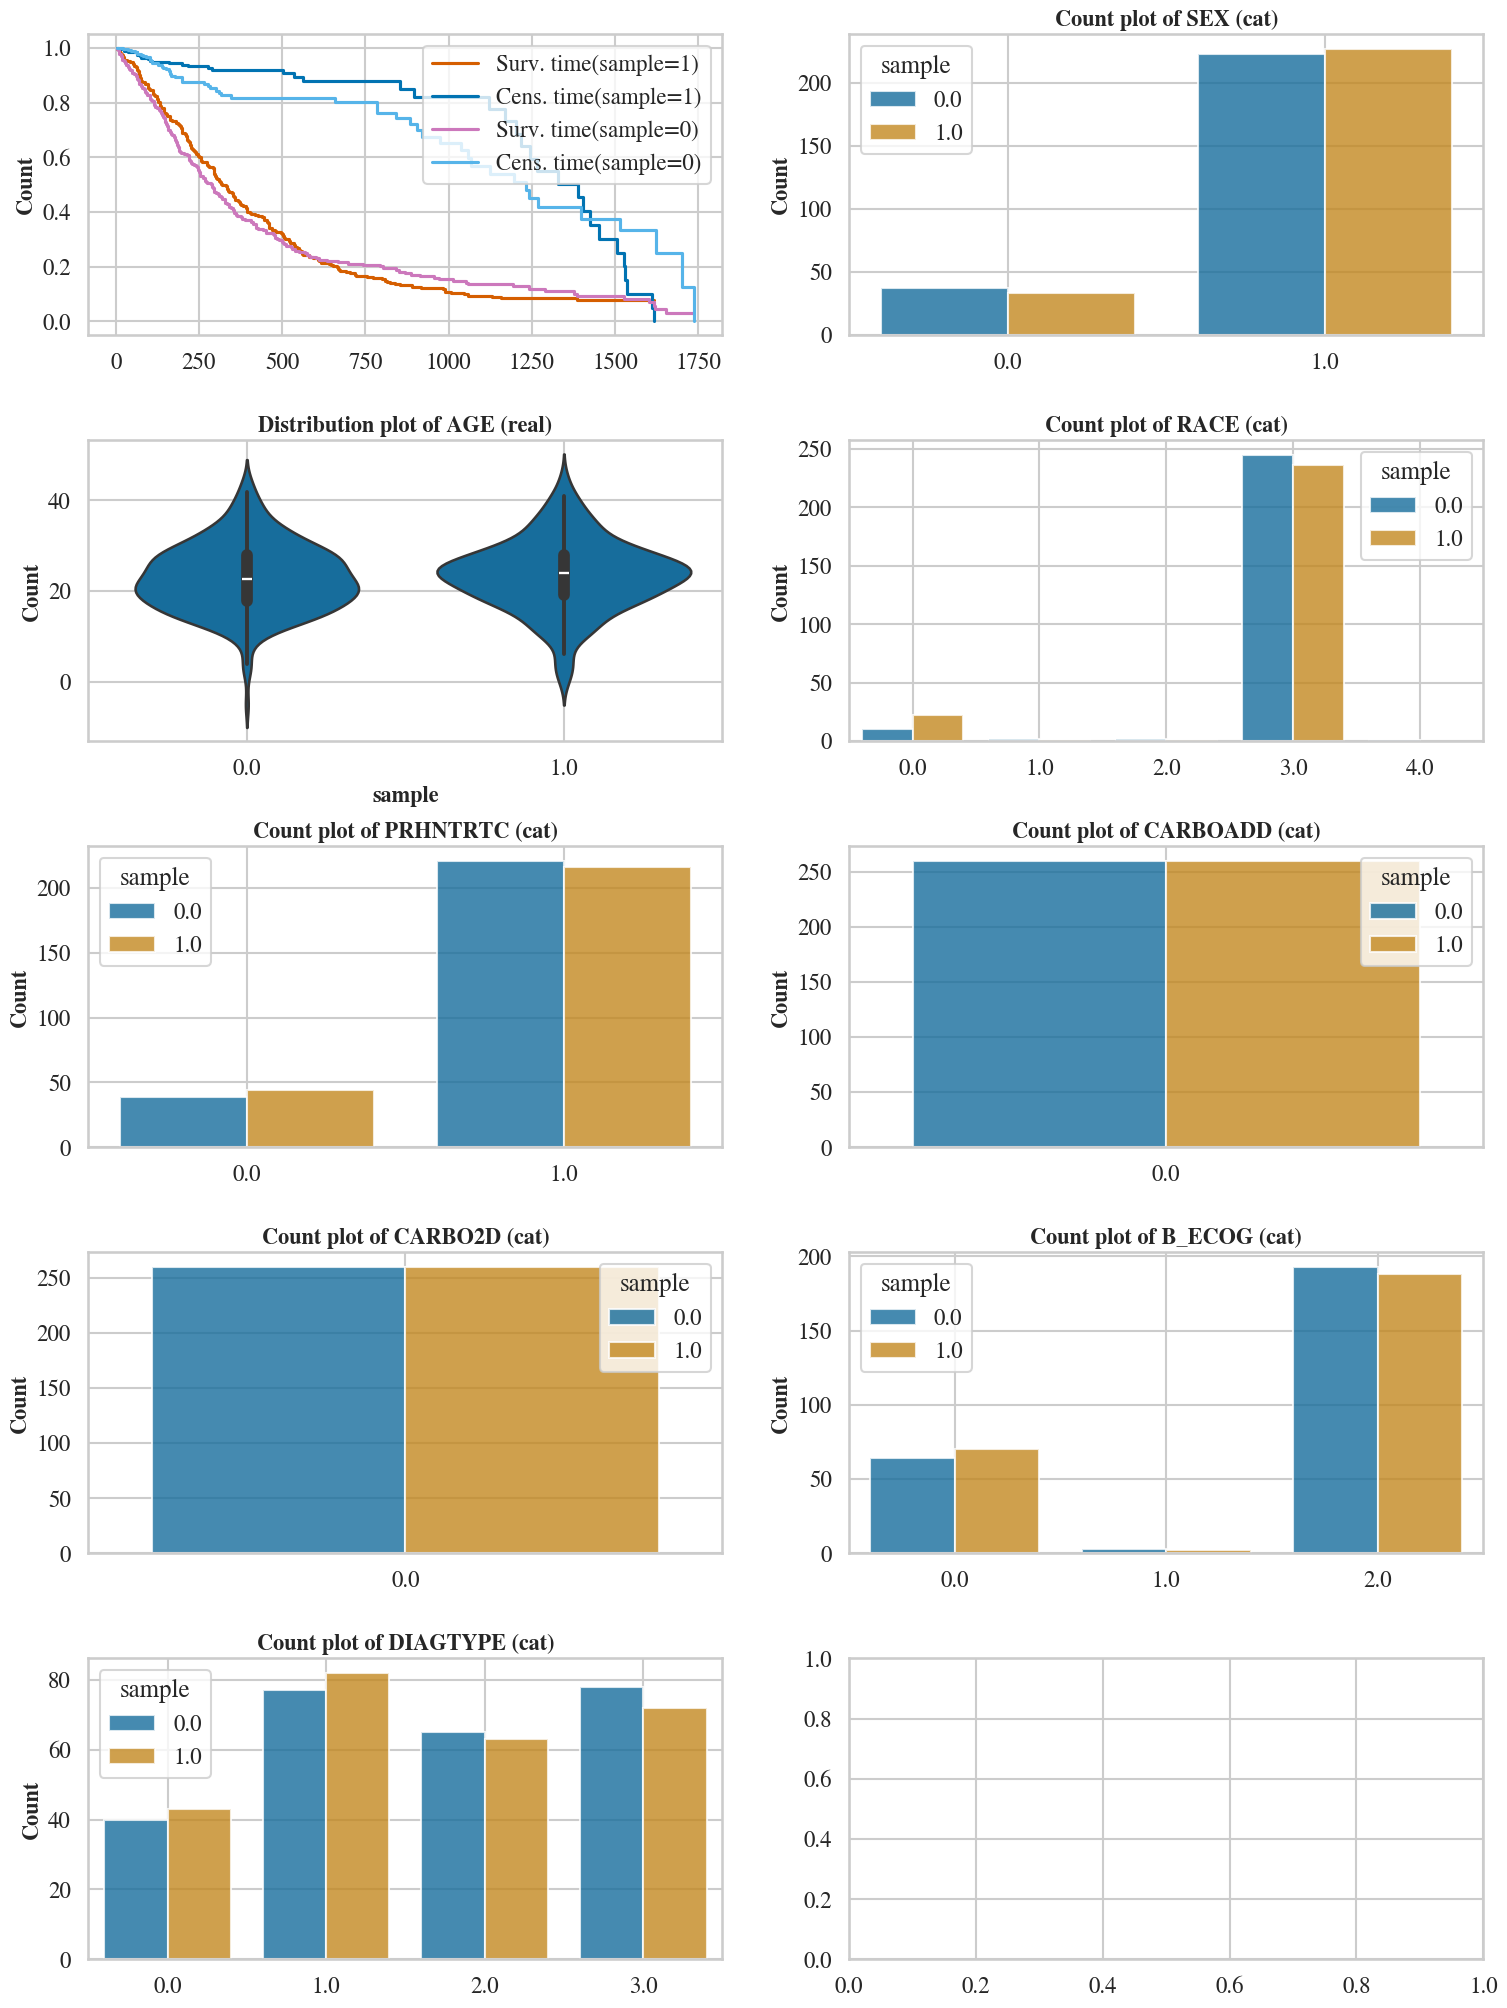

In [10]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 0
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

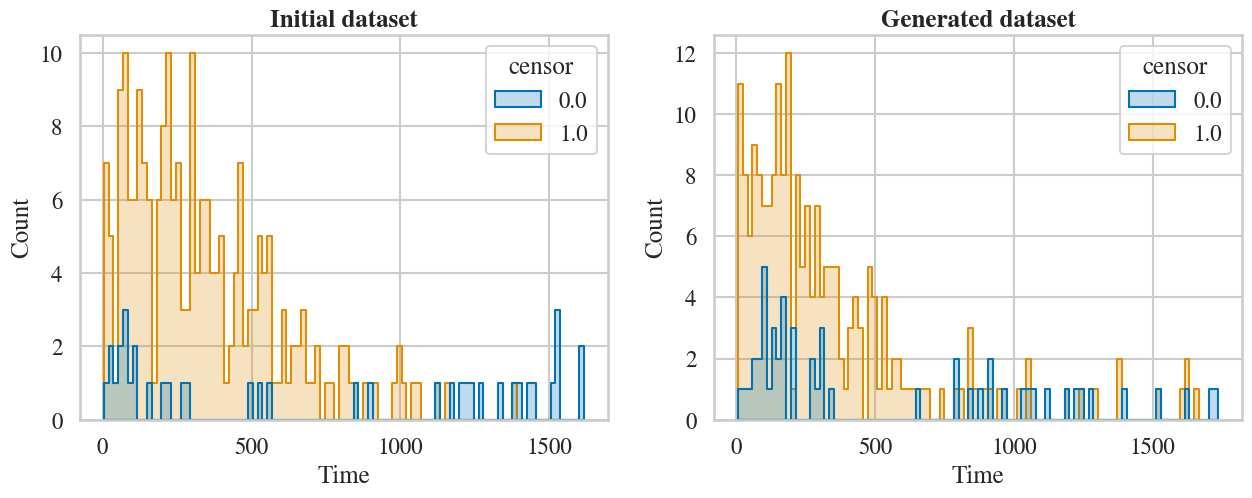

In [11]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=control, x="time", hue="censor", bins=100, element="step", stat="count", common_bins=True, ax=axs[0])
axs[0].set_title("Initial dataset", fontsize=18, fontweight="semibold")
axs[0].set_xlabel("Time", fontsize=18)
sns.histplot(data=df_gen_control_ext_sel, x="time", hue="censor", bins=100, element="step", stat="count", common_bins=True, ax=axs[1])
axs[1].set_title("Generated dataset", fontsize=18, fontweight="semibold")
axs[1].set_xlabel("Time", fontsize=18)
plt.show()

In [12]:
categorical = ['censor', 'SEX', 'RACE', 'PRHNTRTC', 'CARBOADD', 'CARBO2D', 'B_ECOG', 'DIAGTYPE', 'sample']
continuous = ['time', 'AGE']
nonnormal = ['time']
table1 = TableOne(df_control_sel, categorical=categorical, continuous=continuous, groupby='sample', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by sample                                                                       
                                   Missing              Overall                    0                    1 P-Value
n                                                           520                  260                  260        
time, median [Q1,Q3]                     0  263.8 [128.0,514.3]  237.9 [117.0,480.0]  296.0 [133.8,536.5]   0.081
censor, n (%)        0.0                              92 (17.7)            53 (20.4)            39 (15.0)   0.135
                     1.0                             428 (82.3)           207 (79.6)           221 (85.0)        
SEX, n (%)           0.0                              70 (13.5)            37 (14.2)            33 (12.7)   0.700
                     1.0                             450 (86.5)           223 (85.8)           227 (87.3)        
AGE, mean (SD)                           0           23.2 (7.7)           22.9 (7.6)    

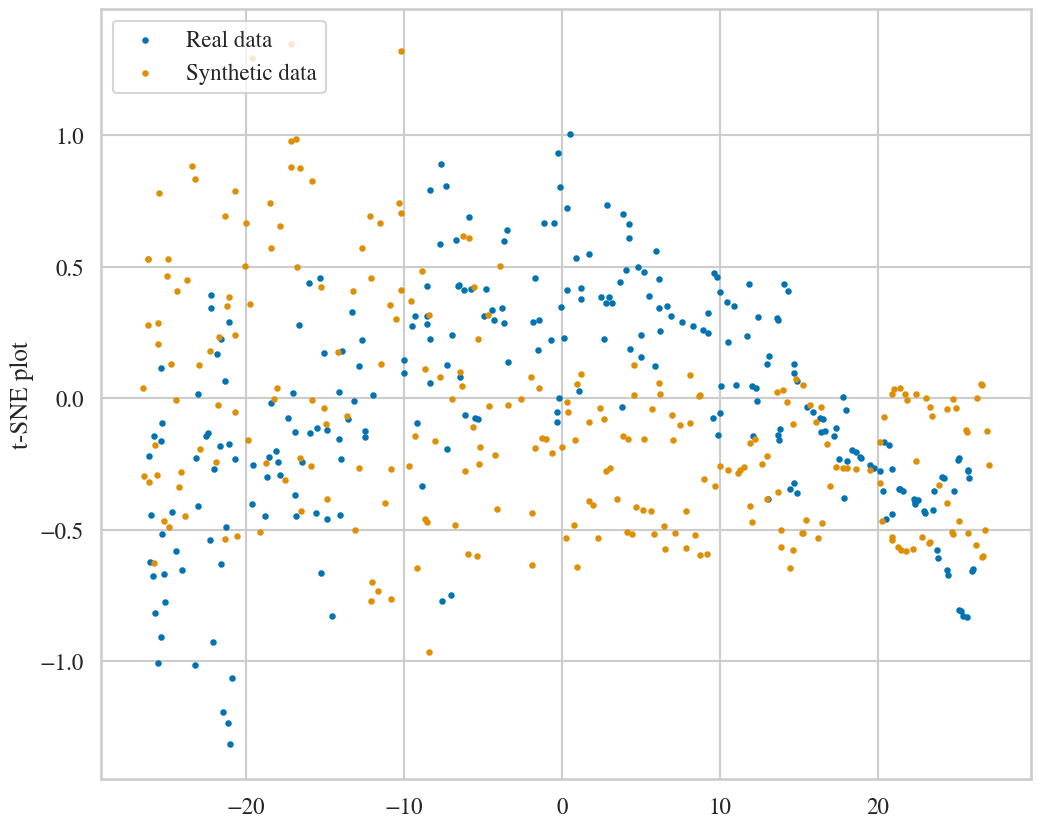

In [13]:
synthcity_dataloader_init = SurvivalAnalysisDataLoader(df_init_control, target_column = "censor", time_to_event_column = "time")
synthcity_dataloader_syn = SurvivalAnalysisDataLoader(df_gen_control_ext_sel, target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, synthcity_dataloader_init, synthcity_dataloader_syn)

### 3.2. Statistical analysis: one generated control group vs. initial treated data

In [14]:
list_df_gen_control = []
for j in range(n_generated_dataset):
    df_gen_control_j = pd.DataFrame(data_gen_control[j].numpy(), columns=control_fnames)
    df_gen_control_j['treatment'] = 0
    list_df_gen_control.append(df_gen_control_j)

sel_idx = 0
df_gen_control_sel = list_df_gen_control[sel_idx]
df_syn_sel = pd.concat([df_init_treated, df_gen_control_sel], ignore_index=True)

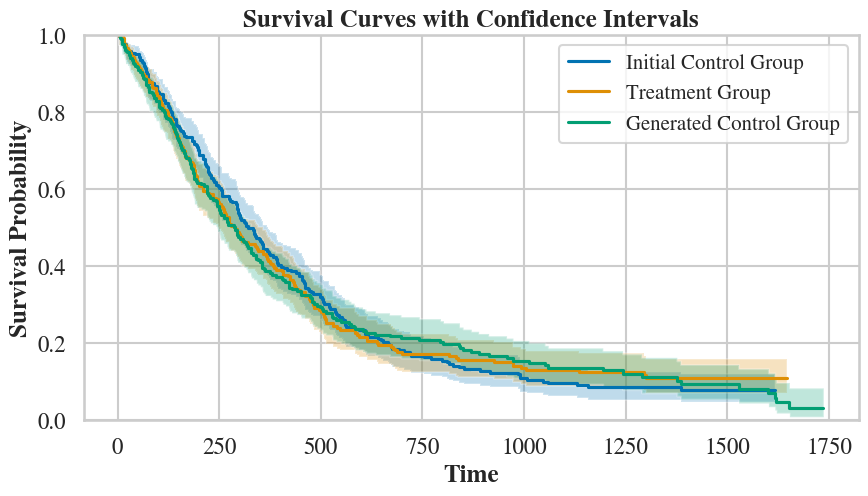

In [15]:
surv_time_control_init = df_init[df_init['treatment']==0].to_numpy()[:,0]
surv_ind_control_init = df_init[df_init['treatment']==0].to_numpy()[:,1].astype(bool)
surv_time_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,0]
surv_ind_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,1].astype(bool)
surv_time_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,0]
surv_ind_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,1].astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [16]:
categorical = ['censor', 'SEX', 'RACE', 'PRHNTRTC', 'CARBOADD', 'CARBO2D', 'B_ECOG', 'DIAGTYPE', 'treatment']
continuous = ['time', 'AGE']
nonnormal = ['time']
table1 = TableOne(df_syn_sel, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                       
                                      Missing              Overall                    0                    1 P-Value
n                                                              520                  260                  260        
time, median [Q1,Q3]                        0  246.5 [117.0,480.5]  237.9 [117.0,480.0]  252.0 [119.2,480.5]   0.839
censor, n (%)        0.0                                109 (21.0)            53 (20.4)            56 (21.5)   0.829
                     1.0                                411 (79.0)           207 (79.6)           204 (78.5)        
SEX, n (%)           0.0                                 69 (13.3)            37 (14.2)            32 (12.3)   0.605
                     1.0                                451 (86.7)           223 (85.8)           228 (87.7)        
AGE, mean (SD)                              0           23.5 (7.

## 4. Testing

### 4.1. Univariate testing

In [17]:
from utils.metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

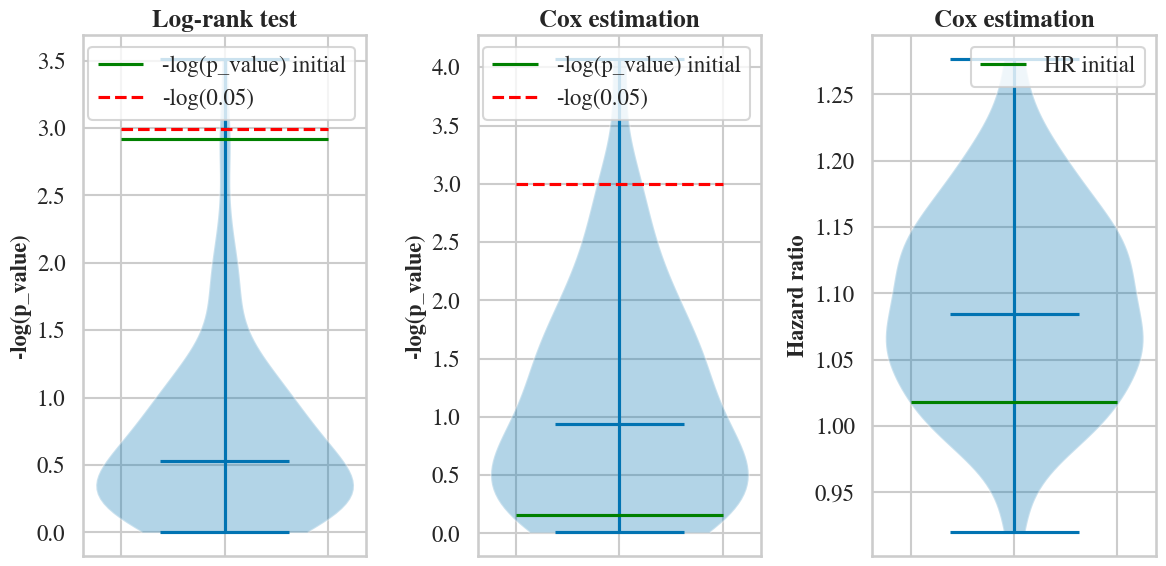

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.2. Stratified testing

#### 4.2.1. Categorical variable

In [19]:
from utils.metrics import strata_log_rank, strata_cox_estimation

# Stratified w.r. karnof analysis
strata_var = 'SEX'
df_init_strata = df_init.copy(deep=True)
df_init_treated_strata = df_init_treated.copy(deep=True)

data_syn_strata = []
for i in range(n_generated_dataset):
    df_gen_control_strata = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control_strata['treatment'] = 0
    data_syn_strata.append(pd.concat([df_init_treated_strata, df_gen_control_strata], ignore_index=True))

strata_LR_init, strata_LR_syn = strata_log_rank(df_init_strata, data_syn_strata, strata=strata_var)
strata_coef_init, strata_coef_syn, strata_cox_p_value_init, strata_cox_p_value_syn = strata_cox_estimation(df_init_strata, data_syn_strata, strata=strata_var)

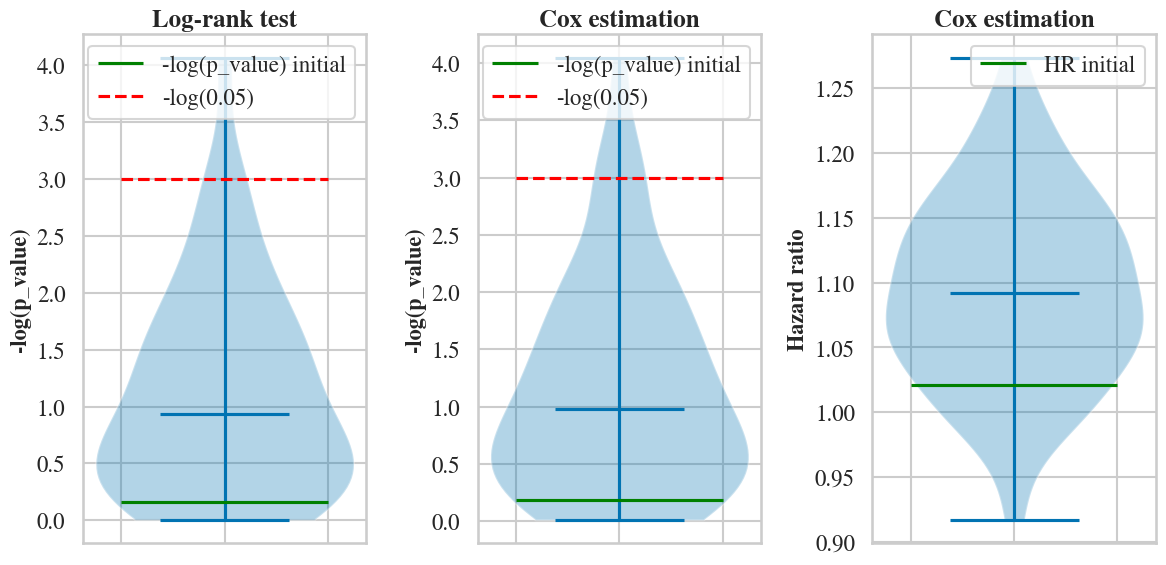

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(strata_LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(strata_LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(strata_cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(strata_cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(strata_coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(strata_coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [21]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

metrics = {
    'sanity': ['nearest_syn_neighbor_distance'],
    'stats': ['jensenshannon_dist', 'ks_test', 'survival_km_distance'],
    'performance': ['feat_rank_distance'],
    'detection': ['detection_xgb'],
    'privacy': ['k-map', 'distinct l-diversity', 'identifiability_score']
}
scores = ScoreEvaluator()
for j in range(n_generated_dataset):
    enable_reproducible_results(j)
    clear_cache()

    synthcity_dataloader_syn = SurvivalAnalysisDataLoader(list_df_gen_control[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                    X_syn=synthcity_dataloader_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=metrics, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(key, mean_score[key], errors[key], duration[key], direction[key])

synthcity_score = scores.to_dataframe()
synthcity_score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.nearest_syn_neighbor_distance.mean,0.051711,0.227898,0.113365,0.041052,0.103496,0.051725,100,0,0.0,minimize
stats.jensenshannon_dist.marginal,0.007435,0.012326,0.009660,0.000995,0.009626,0.001359,100,0,0.0,minimize
stats.ks_test.marginal,0.919097,0.944792,0.931684,0.005061,0.932118,0.007378,100,0,0.0,maximize
stats.survival_km_distance.optimism,0.119394,0.207414,0.155592,0.016982,0.156519,0.019701,100,0,0.0,minimize
stats.survival_km_distance.abs_optimism,0.120730,0.207414,0.156379,0.016862,0.157413,0.019804,100,0,0.0,minimize
stats.survival_km_distance.sightedness,0.026842,0.187357,0.084662,0.031431,0.080950,0.046184,100,0,0.0,minimize
detection.detection_xgb.mean,0.700729,0.808255,0.766074,0.021248,0.765833,0.024466,100,0,0.0,minimize
privacy.k-map.score,1.000000,8.000000,3.100000,1.802776,3.000000,3.250000,100,0,0.0,maximize
privacy.distinct l-diversity.gt,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,100,0,0.0,maximize
privacy.distinct l-diversity.syn,1.000000,9.000000,3.700000,1.819341,3.000000,3.000000,100,0,0.0,maximize
